### Noise

In [1]:
import torch
import numpy as np
from tqdm import tqdm


from cellot.train.utils import get_free_gpu
replica_id = int(get_free_gpu())
device = torch.device(f'cuda:{replica_id}')
from cellot.models.cond_score_module import Pred_X_0_Parameterization
from cellot.data.utils import *

/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Using GPUs: 7


In [2]:
import wandb
run = wandb.init()
artifact = run.use_artifact('protein-optimization/sc_diff/model-ce1o3uhh:v20', type='model')
artifact_dir = artifact.download()

2023-07-26 16:01:54,355 Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnyang (protein-optimization). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [3]:
artifact_dir

'./artifacts/model-ce1o3uhh:v20'

In [4]:
ckpt_path = f'{artifact_dir}/model.ckpt'

In [5]:
import hydra
with hydra.initialize('../configs/diff/'):
    config = hydra.compose(config_name='pred_x_0.yaml')

/tmp/ipykernel_653139/1750149385.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize('../configs/diff/'):
/data/rsg/chemistry/johnyang/miniconda3/envs/cot2/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'pred_x_0.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### Noise

In [6]:
config.score_network.n_layers = 2

In [7]:
config.TARGET = 'trametinib'

In [8]:
lm = Pred_X_0_Parameterization.load_from_checkpoint(hparams=config, checkpoint_path=ckpt_path).to(device)
print('')

2023-07-26 16:02:24,892 Created a temporary directory at /tmp/tmpohv0d3ip
2023-07-26 16:02:24,895 Writing /tmp/tmpohv0d3ip/_remote_module_non_sriptable.py


Dropout is 0.1



In [9]:
# %%
import cellot.models
from cellot.data.cell import load_cell_data
import torch
from cellot.models.ae import AutoEncoder
from pathlib import Path

def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, device, restore=None, **kwargs):
    # def load_autoencoder_model(config, restore=None, **kwargs):
    
    def load_optimizer(config, params):
        kwargs = dict(config.get("optim", {}))
        assert kwargs.pop("optimizer", "Adam") == "Adam"
        optim = torch.optim.Adam(params, **kwargs)
        return optim


    def load_networks(config, **kwargs):
        kwargs = kwargs.copy()
        kwargs.update(dict(config.get("ae", {})))
        name = kwargs.pop("name")

        # if name == "scgen":
        model = AutoEncoder

        # elif name == "cae":
        #     model = ConditionalAutoEncoder
        # else:
        #     raise ValueError

        return model(**kwargs)
    
    model = load_networks(config, **kwargs)
    optim = load_optimizer(config, model.parameters())

    if restore is not None and Path(restore).exists():
        print('Loading model from checkpoint')
        ckpt = torch.load(restore, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optim.load_state_dict(ckpt["optim_state"])
        # if config.model.name == "scgen" and "code_means" in ckpt:
        #     model.code_means = ckpt["code_means"]
            
    # logger.info(f'Model on device {next(model.parameters()).device}')

    return model, optim

def load(config, device, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, device, restore=restore, **model_kwargs)

    return model, opt, loader
# %% [markdown]
# ### Training

# %%
# restore_path = '/Mounts/rbg-storage1/users/johnyang/cellot/saved_weights/ae/ae.pt'
# ae, _ = load_model(config, 'cuda', restore=restore_path, input_dim=1000)
# autoencoder = ae.to(device)

In [10]:
import numpy as np
from scipy.special import gamma
import torch


class LatentDiffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._conf = conf
        self.min_b = conf.min_b
        self.max_b = conf.max_b
        self.schedule = conf.schedule
        self._score_scaling = conf.score_scaling
        self.latent_dim = conf.latent_dim

    def _scale(self, x):
        return x * self._conf.coordinate_scaling

    def _unscale(self, x):
        return x / self._conf.coordinate_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1):
        return np.random.normal(size=(n_samples, self.latent_dim))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def calc_trans_0(self, score_t, x_t, t, use_torch=True):
        beta_t = self.marginal_b_t(t)
        beta_t = beta_t[..., None, None]
        exp_fn = torch.exp if use_torch else np.exp
        cond_var = 1 - exp_fn(-beta_t)
        return (score_t * cond_var + x_t) / exp_fn(-1/2*beta_t)

    def forward(self, x_t_1: np.ndarray, t: float, num_t: int):
        """Samples marginal p(x(t) | x(t-1)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t_1 = self._scale(x_t_1)
        b_t = torch.tensor(self.marginal_b_t(t) / num_t).to(x_t_1.device)
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1
        return x_t
    
    def distribution(self, x_t, score_t, t, mask, dt):
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        std = g_t * np.sqrt(dt)
        mu = x_t - (f_t - g_t**2 * score_t) * dt
        if mask is not None:
            mu *= mask[..., None]
        return mu, std

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions in Angstroms.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t in Angstroms.
            score_t: [..., n, 3] score at time t in scaled Angstroms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_0 = self._scale(x_0)
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        x_t = self._unscale(x_t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')
        
    def ode(self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            noise_scale: float=1.0,
        ):
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)

        # Probability flow ODE
        perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        
        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        
        # For positive dt, we add dx and vv.
        x_t_1 = x_t + perturb
        x_t_1 = self._unscale(x_t_1)
        return x_t_1
        
    def reverse(
            self,
            *,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False,
            noise_scale: float=1.0,
        ):
        """Simulates the reverse SDE for 1 step

        Args:
            x_t: [..., 3] current positions at time t in angstroms.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = self._scale(x_t)
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            z = noise_scale * np.random.normal(size=score_t.shape)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        x_t_1 = self._unscale(x_t_1)
        return x_t_1

    def conditional_var(self, t, use_torch=False):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        if use_torch:
            return 1 - torch.exp(-self.marginal_b_t(t))
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t, use_torch=False, scale=False):
        if use_torch:
            exp_fn = torch.exp
        else:
            exp_fn = np.exp
        if scale:
            x_t = self._scale(x_t)
            x_0 = self._scale(x_0)
        return -(x_t - exp_fn(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t, use_torch=use_torch)

In [44]:
from cellot.utils.dev_utils import get_target_cond_idx
import numpy as np

gammas = np.logspace(1, -3, num=50)

def forward_ODE(x_t, score_t, t, dt):
    return lm.diffuser.ode(x_t=x_t.detach().cpu().numpy(), score_t=score_t.detach().cpu().numpy(), t=t, dt=dt)

def reverse_ODE(x_t, score_t, t, dt):
    return lm.diffuser.ode(x_t=x_t.detach().cpu().numpy(), score_t=score_t.detach().cpu().numpy(), t=t, dt=-dt)

def forward_diffuse_to_t(x_t, t, dt, fwd_y):
    with torch.inference_mode():
        x_t_fwd = x_t
        for fwd_t in np.arange(0 + dt, t + dt, dt):
            x_t_fwd = torch.tensor(x_t_fwd).float().to(device)
            pred_x_0 = lm.score_network((x_t_fwd, fwd_y), fwd_t)
            fwd_cond_score = lm.diffuser.score(x_t_fwd, pred_x_0, fwd_t, use_torch=True)
            x_t_fwd = forward_ODE(x_t_fwd, fwd_cond_score, fwd_t, lm.dt)
        return x_t_fwd

def reverse_diffuse_from_t(x_t, t, dt, reverse_y):
    with torch.inference_mode():
        x_t_rvs = x_t
        for rvs_t in np.arange(t, 0, -dt):
            x_t_rvs = torch.tensor(x_t_rvs).float().to(device)
            pred_x_0 = lm.score_network((x_t_rvs, reverse_y), rvs_t)
            rvs_cond_score = lm.diffuser.score(x_t_rvs, pred_x_0, rvs_t, use_torch=True)
            x_t_rvs = reverse_ODE(x_t_rvs, rvs_cond_score, rvs_t, lm.dt)
        return x_t_rvs

def inference(lm, batch, lamb=4, dt=0.01, t_start=1.0, cond=True, ae=None, target=None):
    device = lm.device
    # assert ae is not None, 'Must provide autoencoder'
    assert target is not None or not cond, 'Must provide target'
    
    with torch.inference_mode():
        lm.eval()
        all_genes_x, y_batch = batch
        fwd_y = y_batch.to(device)

        # Forward ODE calculations
        x_t_fwd = all_genes_x
        for fwd_t in np.arange(0 + dt, t_start, dt):
            x_t_fwd = torch.tensor(x_t_fwd).float().to(device)
            pred_x_0 = lm.score_network((x_t_fwd, fwd_y), fwd_t)
            fwd_cond_score = lm.diffuser.score(x_t_fwd, pred_x_0, fwd_t, use_torch=True)
            x_t_fwd = forward_ODE(x_t_fwd, fwd_cond_score, fwd_t, lm.dt)
            
        diffuser_code = x_t_fwd.copy()

        # Prepare for reverse calculations
        x_t = x_t_fwd
        reverse_y = torch.ones_like(y_batch) * get_target_cond_idx(target) if cond else y_batch
        # print(f'In reverse, Conditioning on {reverse_y}')
        # Reverse ODE calculations
        for reverse_t in np.arange(t_start, 0 - dt, -dt):
            x_t = torch.tensor(x_t).float().to(device)
            pred_x_0 = lm.score_network((x_t, reverse_y), reverse_t)
            rvs_cond_score = lm.diffuser.score(x_t, pred_x_0, reverse_t, use_torch=True)
            x_t = reverse_ODE(x_t, rvs_cond_score, reverse_t, lm.dt)
        
        # Decode final result
        x_0 = torch.tensor(x_t, dtype=torch.float).to(lm.device)
        # recon = ae.eval().decode(x_0)
        return x_0, diffuser_code

In [12]:
from imp import reload
reload(cellot.utils.dev_utils)

/tmp/ipykernel_653139/3036645331.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


<module 'cellot.utils.dev_utils' from '/Mounts/rbg-storage1/users/johnyang/cellot/cellot/utils/dev_utils.py'>

In [13]:
from cellot.utils.dev_utils import load_markers

sel_mg, gene_idxs = load_markers(config)
sel_mg

2023-07-26 16:02:40,904 Loaded cell data with TARGET trametinib and OBS SHAPE (20842, 16)


Index(['ENSG00000198074.9', 'ENSG00000019186.9', 'ENSG00000108846.15',
       'ENSG00000115414.18', 'ENSG00000231185.6', 'ENSG00000112541.13',
       'ENSG00000117983.17', 'ENSG00000145819.15', 'ENSG00000184588.17',
       'ENSG00000165376.10', 'ENSG00000154529.14', 'ENSG00000182752.9',
       'ENSG00000251003.7', 'ENSG00000101144.12', 'ENSG00000117724.12',
       'ENSG00000157168.18', 'ENSG00000275395.5', 'ENSG00000185483.11',
       'ENSG00000108405.3', 'ENSG00000089199.9', 'ENSG00000254166.2',
       'ENSG00000215182.8', 'ENSG00000004948.13', 'ENSG00000227706.3',
       'ENSG00000065809.13', 'ENSG00000004799.7', 'ENSG00000144847.12',
       'ENSG00000107957.16', 'ENSG00000108602.17', 'ENSG00000059804.15',
       'ENSG00000047648.21', 'ENSG00000076706.16', 'ENSG00000003436.15',
       'ENSG00000229140.8', 'ENSG00000066279.17', 'ENSG00000153956.15',
       'ENSG00000086548.8', 'ENSG00000171408.13', 'ENSG00000005108.15',
       'ENSG00000138696.10', 'ENSG00000236213.1', 'ENSG0000003842

In [14]:
def DEV_load_ae_cell_data(
        config,
        data=None,
        split_on=None,
        return_as="loader",
        include_model_kwargs=False,
        pair_batch_on=None,
        ae=None,
        encode_latents=False,
        sel_mg=None,
        **kwargs
    ):
        assert ae is not None or not encode_latents, "ae must be provided"
        
        if isinstance(return_as, str):
            return_as = [return_as]

        assert set(return_as).issubset({"anndata", "dataset", "loader"})
        config.data.condition = config.data.get("condition", "drug")
        condition = config.data.condition
        
        data = read_single_anndata(config, **kwargs)
        
        inputs = torch.Tensor(
            data.X if not sparse.issparse(data.X) else data.X.todense()
        )

        if encode_latents:
            genes = data.var_names.to_list()
            data = anndata.AnnData(
                ae.eval().encode(inputs).detach().numpy(),
                obs=data.obs.copy(),
                uns=data.uns.copy(),
            )
            data.uns["genes"] = genes


        # cast to dense and check for nans
        if sparse.issparse(data.X):
            data.X = data.X.todense()
        assert not np.isnan(data.X).any()

        if sel_mg is not None:
            data = data[:, sel_mg]

        dataset_args = dict()
        model_kwargs = {}

        model_kwargs["input_dim"] = data.n_vars

        # if config.get("model.name") == "cae":
        condition_labels = sorted(data.obs[condition].cat.categories)
        model_kwargs["conditions"] = condition_labels
        dataset_args["obs"] = condition
        dataset_args["categories"] = condition_labels

        if "training" in config:
            pair_batch_on = config.training.get("pair_batch_on", pair_batch_on)

        # if split_on is None:
            # if config.model.name == "cellot":
            #     # datasets & dataloaders accessed as loader.train.source
        split_on = ["split", "transport"]
        if pair_batch_on is not None:
            split_on.append(pair_batch_on)

            # if (config.ae.name == "scgen" #or config.ae.name == "cae"
            #     #or config.ae.name == "popalign"):
            # split_on = ["split"]

            # else:
            #     raise ValueError

        if isinstance(split_on, str):
            split_on = [split_on]

        for key in split_on:
            assert key in data.obs.columns

        if len(split_on) > 0:
            splits = {
                (key if isinstance(key, str) else ".".join(key)): data[index]
                for key, index in data.obs[split_on].groupby(split_on).groups.items()
            }

            dataset = nest_dict(
                {
                    key: AnnDataDataset(val.copy(), **dataset_args)
                    for key, val in splits.items()
                },
                as_dot_dict=True,
            )
        else:
            dataset = AnnDataDataset(data.copy(), **dataset_args)

        if "loader" in return_as:
            kwargs = dict(config.dataloader)
            kwargs.setdefault("drop_last", True)
            loader = cast_dataset_to_loader(dataset, **kwargs)

        returns = list()
        for key in return_as:
            if key == "anndata":
                returns.append(data)

            elif key == "dataset":
                returns.append(dataset)

            elif key == "loader":
                returns.append(loader)

        if include_model_kwargs:
            returns.append(model_kwargs)

        if len(returns) == 1:
            return returns[0]

        # returns.append(data)

        return tuple(returns)

In [15]:
datasets = DEV_load_ae_cell_data(config, return_as='dataset')#, ae=autoencoder.cpu(), encode_latents=True)#, sel_mg=sel_mg)

In [16]:
loader = cast_dataset_to_loader(datasets, batch_size=256, shuffle=False, drop_last=False)
loader

{'test': {'source': <torch.utils.data.dataloader.DataLoader at 0x7f3fbe65ed90>,
  'target': <torch.utils.data.dataloader.DataLoader at 0x7f3fbe65ee50>},
 'train': {'source': <torch.utils.data.dataloader.DataLoader at 0x7f3fc475d550>,
  'target': <torch.utils.data.dataloader.DataLoader at 0x7f3fdeae0130>}}

In [17]:
source = datasets.test.source.adata.X

In [18]:
target = datasets.test.target.adata.X

In [19]:
from cellot.losses.mmd import mmd_distance

def compute_mmd_loss(lhs, rhs, gammas):
    return np.mean([mmd_distance(lhs, rhs, g) for g in gammas])

In [64]:
# Define list variables
gts, recons, uncond_recons, d_codes, uncond_d_codes = [], [], [], [], []

loss_list = []

# Function for inference and data gathering
def process_batch(batch):
    batch = [x.to(device) for x in batch]
    gts.append(batch)

    # Conditioned inference
    recon, diffuser_code = inference(
        lm, batch, lamb=4, dt=0.01, t_start=1.0, cond=True, ae=None, target=config.TARGET)

    # Unconditioned inference
    uncond_recon, uncond_d_code = inference(
        lm, batch, ae=None, lamb=4, dt=0.01, t_start=1.0, cond=False, target=config.TARGET)

    # Data gathering
    recons.append(recon.detach().cpu().numpy())
    d_codes.append(diffuser_code)
    uncond_d_codes.append(uncond_d_code)
    uncond_recons.append(recon.detach().cpu().numpy())
    
# Process batches
# for batch in tqdm(loader.train.source):
#     process_batch(batch)

for batch in tqdm(loader.test.source):
    process_batch(batch)

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_2514678/3488915816.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)
100%|██████████| 14/14 [07:16<00:00, 31.17s/it]


In [32]:
ex_cell = torch.tensor(source[0][None]).to(device)
ex_cell.shape

torch.Size([1, 1000])

In [33]:
ex_cell

tensor([[3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 3.0313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.7000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.0313, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [66]:
fwd_code = forward_diffuse_to_t(ex_cell, 1.0, 0.1, torch.zeros([1]).int().to(device))
fwd_code

/tmp/ipykernel_653139/4248960729.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_fwd = torch.tensor(x_t_fwd).float().to(device)


array([[ 4.03174639e+00,  2.18753400e-03, -5.58703393e-03,
        -9.40006413e-03, -5.46452915e-03, -2.04799278e-03,
        -2.49230885e-04,  1.96265317e-02,  4.58918716e-04,
         4.26477706e-03, -2.67614257e-02,  3.41307838e-03,
         7.36063113e-04,  1.15312366e-02, -3.60077098e-02,
        -6.75315112e-02,  4.90147341e-03,  9.03910026e-02,
         3.92752327e-03,  2.66067171e-03, -1.05156183e-01,
        -8.71699154e-02,  7.76544586e-03, -6.10980988e-02,
        -1.18382769e-02,  1.73417494e-01, -1.93229079e-01,
         4.01506871e-02, -1.00255432e-02, -4.20779135e-04,
         7.22468540e-04, -6.15361407e-02,  1.54733472e-02,
        -4.36910987e-02,  1.37573434e-02,  4.05714195e-03,
        -7.16087874e-03, -2.76608262e-02,  3.20875978e+00,
        -7.61888847e-02, -3.38260829e-02,  6.24488965e-02,
         1.05781935e-03, -4.80846316e-02,  9.22777038e-03,
        -6.68962346e-03, -1.17770992e-01, -1.15998000e-01,
        -2.11302370e-01, -1.11672319e-02, -3.29085514e-0

In [67]:
recon = reverse_diffuse_from_t(fwd_code, 1.0, 0.1, torch.zeros([1]).int().to(device))

In [77]:
non_zero_gene_inds = torch.where(ex_cell > 0)
non_zero_gene_inds

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:7'),
 tensor([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225, 228,
         235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535, 560, 664,
         682, 741, 757, 841, 870, 883, 910, 958], device='cuda:7'))

In [74]:
non_zero_recon_inds = np.where(recon > 0.1)
non_zero_recon_inds

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,  38,  73,  88,  97, 121, 122, 145, 162, 164, 201, 203, 225,
        228, 235, 254, 267, 285, 300, 339, 407, 436, 460, 473, 501, 535,
        560, 664, 682, 741, 757, 841, 870, 883, 910, 958]))

In [ ]:
zeroed_recon = np.where(recon > 0.1, recon, 0)
zeroed_recon

In [50]:
d_codes.__len__()

14

In [ ]:
uncon

In [51]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Convert d_codes list into a numpy array
d_codes_arr = np.concatenate(d_codes, axis=0)

# Extract labels from gts
# labels = torch.cat([item[1] for item in gts], dim=0).cpu().numpy()

# UMAP transformation
reducer = umap.UMAP()
embedding = reducer.fit_transform(d_codes_arr)

# Plotting
plt.figure(figsize=(10,8))

# Create a scatter plot with labels
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral')

# Create a colorbar
cbar = plt.colorbar(scatter)
# cbar.set_label('Labels')

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the d_codes', fontsize=24)
plt.show()

KeyboardInterrupt: 

In [53]:
all_recons = np.concatenate(recons, axis=0)

In [56]:
all_recons.shape

(3513, 1000)

In [57]:
target = datasets.test.target.adata.X
target.shape

(656, 1000)

In [58]:
def compute_mmd_on_selected_genes(recon, target, selected_genes, gammas):
    return compute_mmd_loss(recon[:, selected_genes], target[:, selected_genes], gammas)

In [67]:
gt_xs = torch.cat([x[0] for x in gts], axis=0).cpu().numpy()

In [70]:
np.mean((all_recons - gt_xs)**2)

0.008567453

In [60]:
mmd_loss = compute_mmd_on_selected_genes(all_recons, target, gene_idxs, gammas)

In [71]:
all_recons

array([[ 1.7656345e+00, -3.5206070e-03,  8.6536370e-03, ...,
        -7.6069497e-05,  3.4276128e-02,  1.5604109e-02],
       [ 9.9193919e-03, -2.1153591e-03, -9.6039707e-04, ...,
         3.3627255e-03,  3.3874260e-03,  1.4049064e-03],
       [-9.3704206e-04, -7.1847416e-04,  3.4779486e-01, ...,
         4.4487584e-03, -6.6366857e-03,  1.2764533e-03],
       ...,
       [ 1.3531349e-02, -6.4687140e-04, -7.7381572e-03, ...,
         1.8194144e-03,  5.3733070e-03,  4.3629105e-03],
       [-5.6003887e-02,  1.0561042e-02, -1.1303816e-02, ...,
        -1.0561353e-02,  2.3853979e-03, -1.0597404e-02],
       [ 3.2460045e-02, -2.7917342e-03,  1.3893714e-02, ...,
         4.7480846e-03,  1.8447407e-02,  4.6414565e-03]], dtype=float32)

In [61]:
mmd_loss

0.01700967229437083

In [30]:
tgts = []
for batch in loader.train.target:
    tgts.append(batch[0])

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def plot_marker_gene_expression(all_gts, target, all_recon, all_uncond_recons, gene_idxs, gene_names, cutoff=0.1, font_size=32, fig_title='Top 5 Marker Gene Expression Histograms for Trametinib Perturbation'):
    # Prepare figure and axes
    fig, axs = plt.subplots(len(gene_idxs), 4, figsize=(50, 40))
    plt.rcParams.update({'font.size': font_size})  # Update font size

    for i in range(len(gene_idxs)):
        # Extract values
        source_values = all_gts[:, gene_idxs[i]]
        target_values = target[:, gene_idxs[i]]
        recon_values = all_recon[:, gene_idxs[i]]
        uncond_recon_values = all_uncond_recons[:, gene_idxs[i]]
        # latent_iden_recon_values = all_latent_identities[:, gene_idxs[i]]

        # Create subplots
        axs[i][0].hist(source_values[source_values > cutoff])
        axs[i][0].set_title('Source')
        axs[i][1].hist(target_values[target_values > cutoff])
        axs[i][1].set_title('Target')
        axs[i][2].hist(recon_values[recon_values > cutoff])
        axs[i][2].set_title('Cond Recon')
        axs[i][3].hist(uncond_recon_values[uncond_recon_values > cutoff])
        axs[i][3].set_title('Uncond Recon')
        # axs[i][4].hist(latent_iden_recon_values[latent_iden_recon_values > cutoff])
        # axs[i][4].set_title('Latent Iden Recon')

        axs[i][0].set_ylabel(gene_names[i])

    # Adjust figure and show
    fig.subplots_adjust(top=0.95)  # Adjust as needed
    fig.suptitle(fig_title)
    plt.show()


In [29]:
all_gts = torch.cat([item[0] for item in gts], axis=0).cpu().numpy()

In [39]:
all_target = torch.cat(tgts, axis=0).cpu().numpy()

In [73]:
all_uncond_recons = np.concatenate(uncond_recons, axis=0)

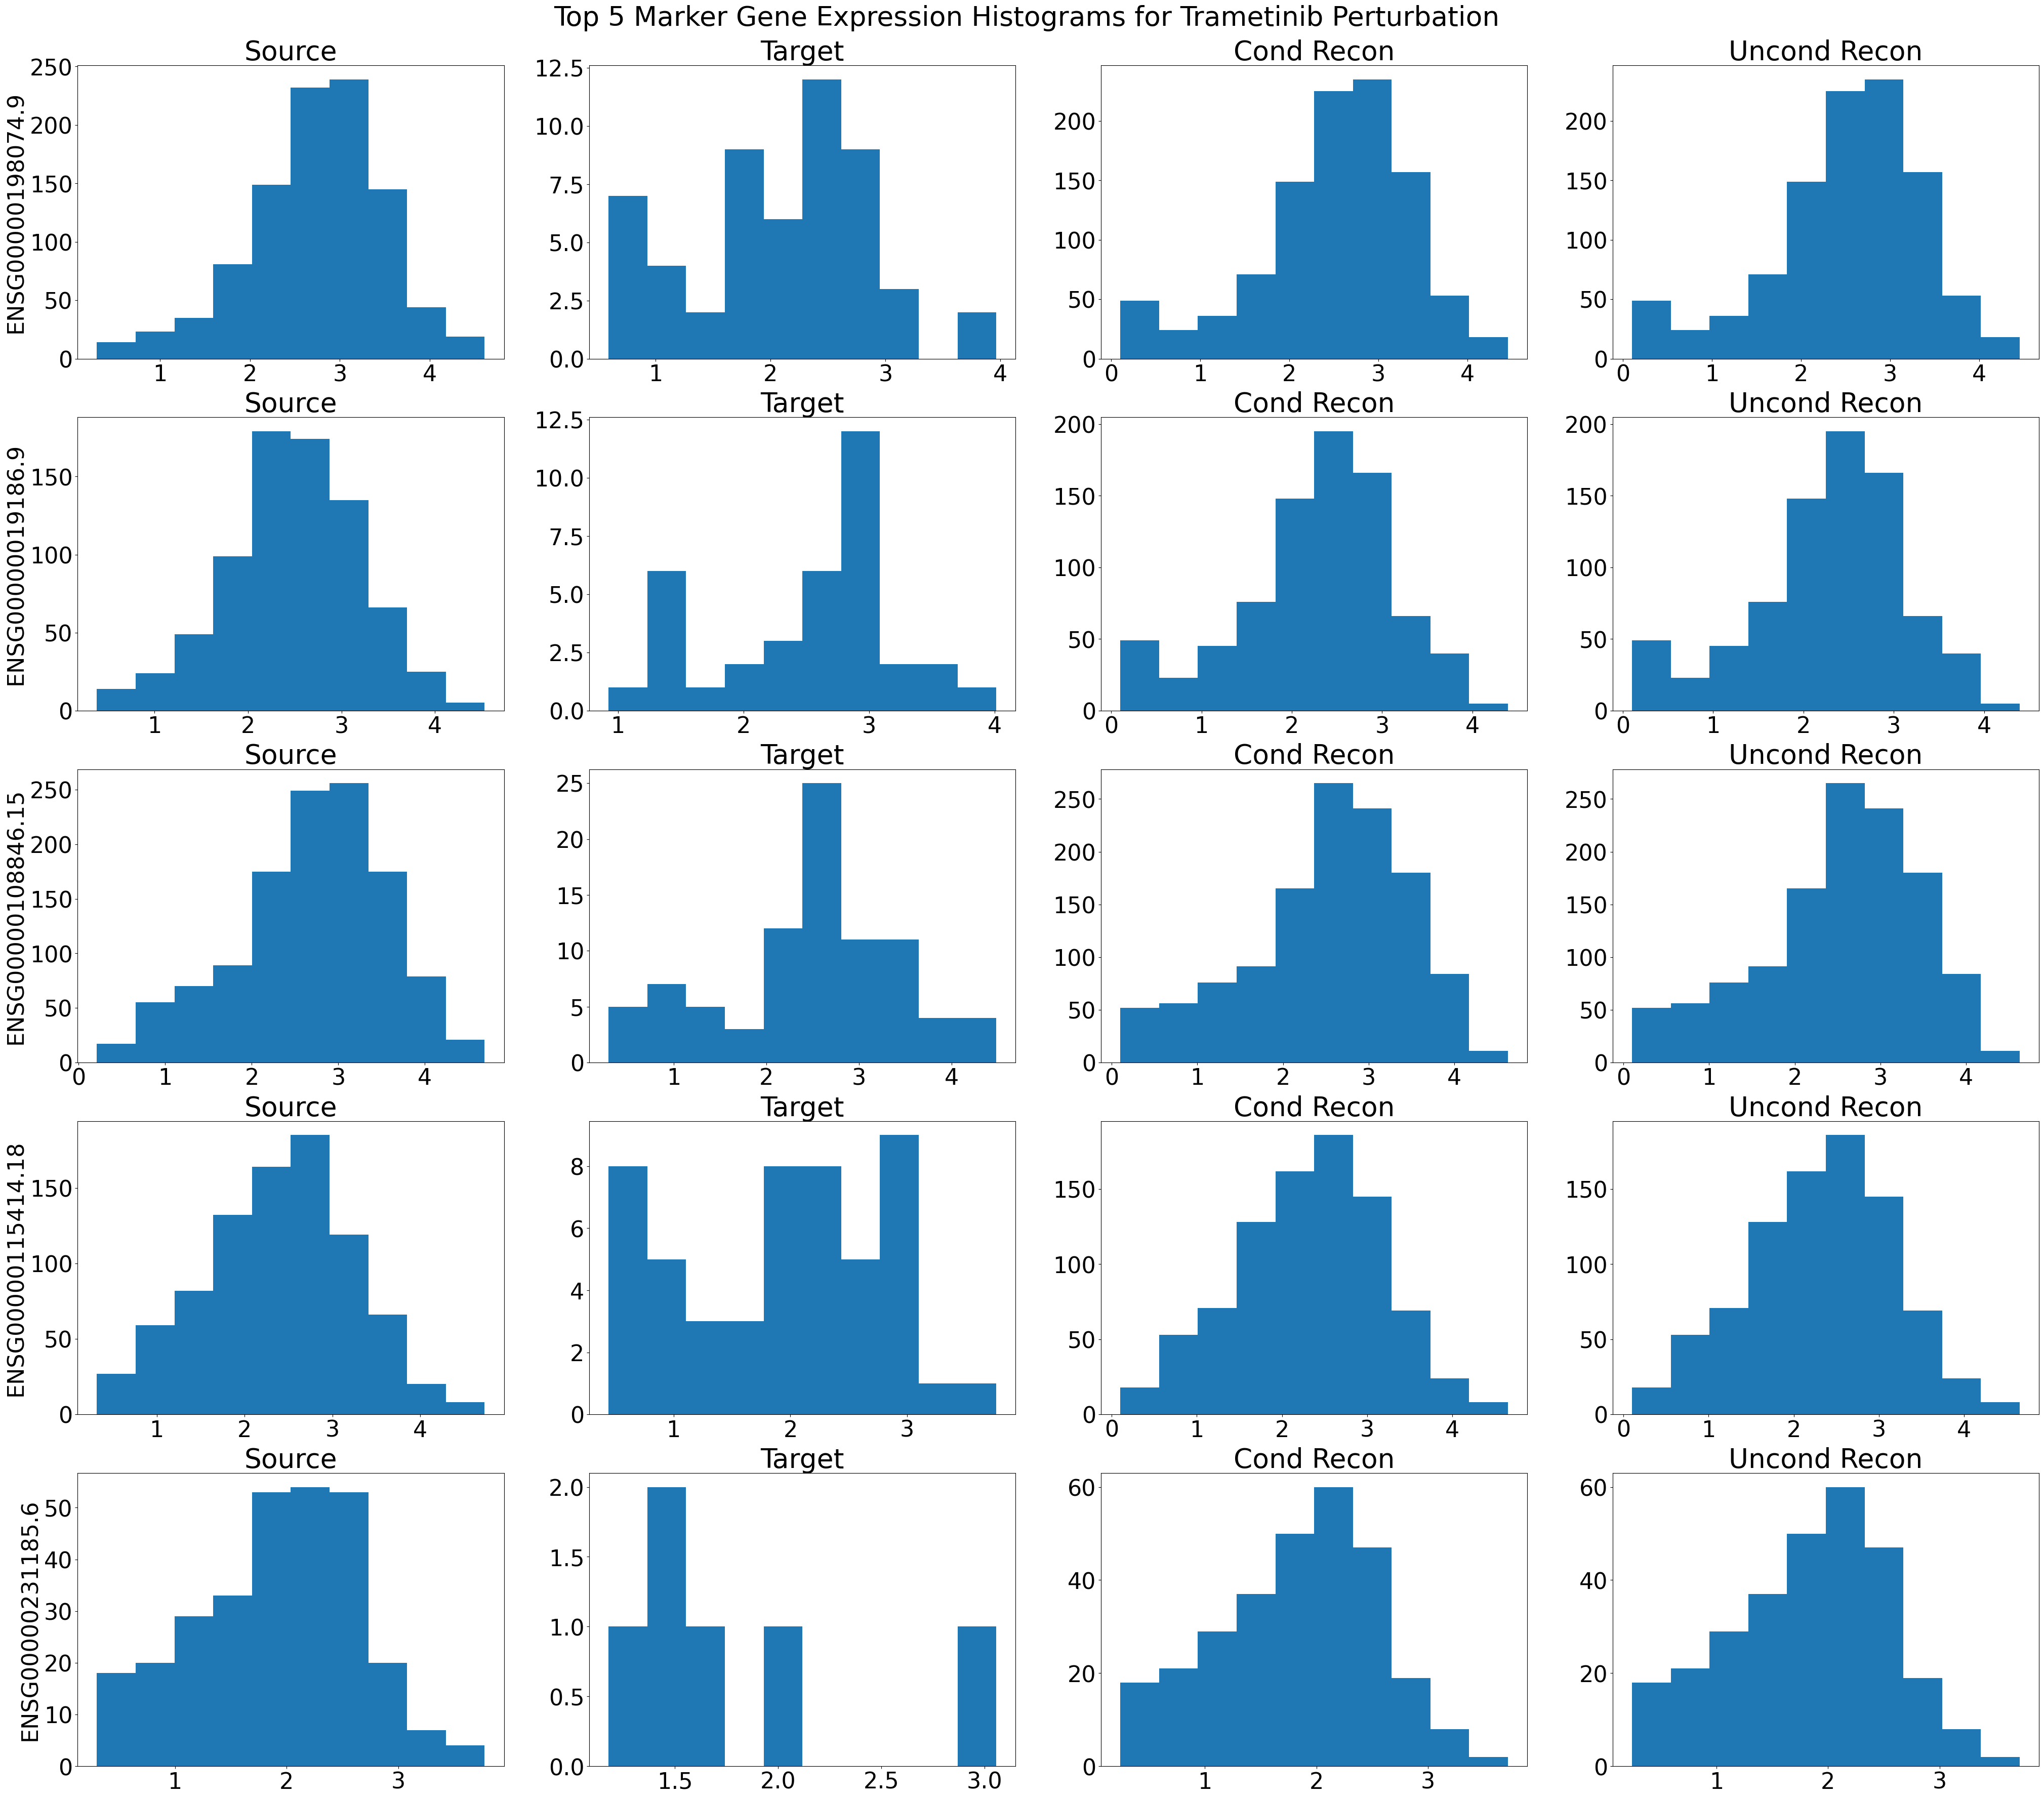

In [86]:
plot_marker_gene_expression(gt_xs, target, all_recons, all_uncond_recons, gene_idxs[:5], sel_mg[:5])

In [ ]:
from cellot import losses
losses.compute_scalar_mmd(all_recon[:, gene_idxs[:50]].detach().cpu().numpy(), sel_target)

0.016602373914793134